In [196]:
import pandas as pd
import torch
from torch import nn, optim, tensor
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import numpy as np

from torch.optim.lr_scheduler import CosineAnnealingLR 

from tqdm import tqdm

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from pathlib import Path

In [3]:
dftraining = pd.read_csv(Path('./data/spaceship-titanic/train.csv'))
dftest = pd.read_csv(Path('./data/spaceship-titanic/test.csv'))

In [4]:
dftraining

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [5]:
dftraining.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
dftraining.fillna(dftraining.mode()).isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
cats = ['HomePlanet', 'Cabin', 'Destination']
conts = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [8]:
dftraining['Cabin'].str[0].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [9]:
dftraining['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [10]:
def clean_df(df, fillmode='median'):
    df = df.drop(['PassengerId', 'Name'], axis = 1)
    
    df['Cabin'] = df['Cabin'].str[0]

    df = pd.get_dummies(df, columns=cats)
    
    fill_method = getattr(df, fillmode)
    df = df.fillna(fill_method())
    
    for cont in conts:
        df[cont] = np.log1p(df[cont].astype(float))
    
    
    return df

In [11]:
clean_df(dftraining).astype(float).head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,0.0,3.688879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,3.218876,0.000000,4.700480,2.302585,3.258097,6.309918,3.806662,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,4.077537,0.693147,3.784190,8.182280,0.000000,8.812248,3.912023,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,3.526361,0.000000,0.000000,7.157735,5.918894,8.110728,5.267858,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,2.833213,0.000000,5.717028,4.262680,5.023881,6.338594,1.098612,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [87]:
def split_df(df, split=0.8):
    train = df.sample(frac=split)
    valid = df.drop(train.index)
    return train, valid

In [88]:
dftrain, dfvalid = split_df(dftraining)

In [89]:
class SpaceTitanic(Dataset):
    def __init__(self, df, fillmode='median', train=True, bs=32, device='cpu'):
        self.train = train
        self.clean_ds = clean_df(df, fillmode)
        
        self.device = device
        
    def __getitem__(self, i):
        row = self.clean_ds.iloc[i].astype(np.float32)
        x = tensor(row.drop(labels=['Transported']))
        y = tensor(row.loc(axis=0)['Transported'])
        return x.to(self.device), y.to(self.device)
        
    def __len__(self):
        return len(self.clean_ds)

In [90]:
class Block(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(n_in),
            nn.Linear(n_in, n_out),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.net(x)

class SpaceTitanicModel(nn.Module):
    def __init__(self, n_in, n_out, n_h, n_hidden_layers=5):
        super().__init__()
        self.model = nn.Sequential(
            Block(n_in, n_h),
            *[Block(n_h, n_h) for i in range(n_hidden_layers)],
            Block(n_h, n_out)
        )
        
    def forward(self, x):
        return self.model(x)

In [91]:
def normalize(tns): return (tns - tns.mean()) / tns.std()

In [227]:
class Learner():
    def __init__(self, model, dls, opt, sched, loss_fn=F.mse_loss, device='cpu'):
        self.model = model.to(device)
        self.dls = dls
        self.opt = opt
        self.loss_fn = loss_fn
        self.sched = sched
        
    def fit(self, epochs=1, plot=True):
        self.losses_train = []
        self.losses_val = []
        self.plot = plot
        self.epochs = epochs
        
        for self.epoch in range(epochs):
            self._fit(True)
            torch.no_grad()(self._fit(False))
            
        if self.plot:
            fig, ax = plt.subplots()
            import IPython; IPython.display.clear_output(wait=True)
            ax.plot(self.losses_train, color="blue", linestyle="-")
            val_pos = [len(self.dls[0]) * (i + 1) for i in range(self.epoch + 1)]
            ax.plot(val_pos, self.losses_val, color="orange", linestyle="--")
            plt.show()

                
    def _fit(self, train=True):
        self.model.train() if train else self.model.eval()
        dl = self.dls[0] if train else self.dls[1]
        loss_val = 0.0
        for x, y in dl:
            x = normalize(x)
            pred = self.model(x)
            pred = pred.view(-1)
            loss = self.loss_fn(pred, y)
            if train:
                loss.backward()
                self.opt.step()
                self.opt.zero_grad()
                self.sched.step()
                self.losses_train.append(loss.item())
                if self.plot:
                    fig, ax = plt.subplots()
                    import IPython; IPython.display.clear_output(wait=True)
                    self.pbar = tqdm(total=self.epochs, initial=self.epoch)
                    
                    ax.plot(self.losses_train, color="blue", linestyle="-")
                    val_pos = [len(self.dls[0]) * (i + 1) for i in range(self.epoch)]
                    ax.plot(val_pos, self.losses_val, color="orange", linestyle="--")
                    plt.show()

            else:
                loss_val += loss.item() * x.shape[0]
                
        if not train:
            loss_val_avg = loss_val / len(dsvalid)
            self.losses_val.append(loss_val_avg)


In [228]:
class Metrics:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.vals, self.ns = [], []
        
    def add(self, inp, targets=None, n=1):
        self.last = self.calc(inp, targets)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum() / np.sum(self.ns)
    
    def calc(self, inp, targets):
        return inp

In [229]:
class Accuracy(Metrics):
    def __init__(self):
        super().__init__()
    
    def calc(self, inp, targets):
        return (inp == targets).float().mean()

In [230]:
def init_model(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

In [231]:
dfvalid.shape

(1739, 14)

In [232]:
clean_df(dfvalid).shape

(1739, 23)

In [233]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dstrain, dsvalid = SpaceTitanic(dftrain, device=device), SpaceTitanic(dfvalid, device=device)

dstrain.clean_ds.shape, dsvalid.clean_ds.shape

((6954, 23), (1739, 23))

In [234]:
bs = 64
dls = DataLoader(dstrain, batch_size=bs), DataLoader(dsvalid, batch_size=bs * 4)
n_features = dstrain.clean_ds.shape[1] - 1

model = SpaceTitanicModel(n_features, 1, 10, 2)
model.apply(init_model)

lr = 0.001
opt = optim.AdamW(model.parameters(), lr=lr)
n_epochs = 1
sched = CosineAnnealingLR(opt, n_epochs * len(dls), lr * 0.5)

In [235]:
learn = Learner(model, dls, loss_fn=F.binary_cross_entropy_with_logits, opt=opt, sched=sched, device=device)

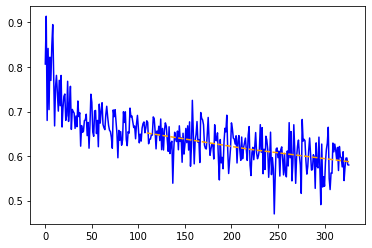

In [236]:
learn.fit(3)

In [ ]:
len(dls[0])

In [45]:
next(iter(dls[1]))[0].shape

torch.Size([256, 21])

In [46]:
next(iter(dls[0]))[0].shape

torch.Size([64, 22])

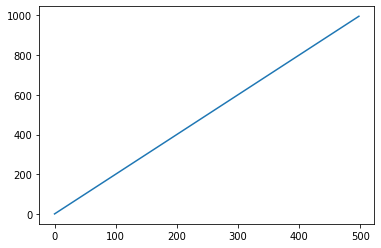

In [142]:
dummies = list(range(0, 1000, 2))


for i in range(len(dummies)):
    fig, ax = plt.subplots()
    import IPython; IPython.display.clear_output(wait=True)
    ax.plot(dummies[:i])
    plt.show()
